1. Load required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly_calplot import calplot

import time
import random
import calmap
import warnings
warnings.filterwarnings('ignore')


sns.set_theme(style="darkgrid")
current_palette = sns.color_palette()


In [2]:
pd.options.display.min_rows = 20
pd.options.display.max_columns = 500


### Load in the data

In [3]:
n= 40000000
s= 1000000
skip = sorted(random.sample(range(1,n),n-s))
df_flights = pd.read_csv("../../data/eda/flights/all_flight_data_20182022/all_flight_data_20182022.zip",skiprows=skip, low_memory=False)


In [4]:
df_flights = df_flights.rename(columns={"Operating_Airline ": "Operating_Airline", "Flight_Number_Operating_Airline": "Flight_Number"})

In [5]:
airlines = pd.read_csv(
    "../../data/databases/flight_attributes/airlines.csv.zip", low_memory=False)
airline_mapper = airlines.set_index("Code")["Description"]

In [6]:
cancellation_codes = pd.read_csv(
    "../../data/databases/flight_attributes/cancellation_codes.csv", low_memory=False)
cancellation_code_mapper = cancellation_codes.set_index(
    "CANCELLATION_REASON")["CANCELLATION_DESCRIPTION"]


In [7]:
usa_airports = (pd.read_csv("../../data/databases/flight_attributes/usa_airports.csv.zip",
                            usecols= ["iata","latitude","longitude"], 
                            low_memory=False))
usa_airports = usa_airports.rename(columns={"iata": "Origin"})



### Data Pre-processing Phase
- EDA
- Feature Engineering
  - Handling missing values
  - Encoding Categorical Variables
- Feature Selection 
- Statistical Analysis
- Train - Test Split

In [8]:
#df_flights.dtypes

In [9]:
def airline_mapping(df_flights):
    df_flights["Operating_Airline"] = (
        df_flights["Operating_Airline"].map(airline_mapper))
    df_flights["CancellationCode"] = (
        df_flights["CancellationCode"].map(cancellation_code_mapper))
    return df_flights

def tweak_df_flights(df_flights):
    SELECTED_COLUMNS = ["FlightDate", "Operating_Airline", "Tail_Number", "Flight_Number", "OriginAirportID",
                        "Origin", "OriginCityName", "OriginState", "OriginStateName", "DestAirportID", "Dest", "DestCityName",
                        "DestState", "DestStateName", "CRSDepTime", "DepTime", "DepDelay", "DepDel15", "DepDelayMinutes", "DepTimeBlk",
                        "TaxiOut", "WheelsOn", "TaxiIn", "CRSArrTime", "ArrTime", "ArrDelayMinutes", "ArrDel15", "ArrTimeBlk",
                        "Cancelled", "CancellationCode", "Diverted", "CRSElapsedTime", "AirTime", "Distance", "CarrierDelay",
                        "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "FirstDepTime", "TotalAddGTime",
                        ]
    df_flights = (
        df_flights[SELECTED_COLUMNS]
        .copy()
    )
    df_flights = (pd.merge(df_flights, usa_airports, how="left", on=["Origin"]))
    df_flights.pipe(airline_mapping)
    return df_flights.assign(
        DepTime=df_flights.DepTime.fillna(0).astype("float16"),
        DepDelay=df_flights.DepDelay.fillna(0).astype("float16"),
        DepDel15=df_flights.DepDel15.fillna(0).astype("float16"),
        DepDelayMinutes=df_flights.DepDelayMinutes.fillna(0).astype("float16"),
        TaxiOut=df_flights.TaxiOut.fillna(0).astype("float16"),
        WheelsOn=df_flights.WheelsOn.fillna(0).astype("float16"),
        TaxiIn=df_flights.TaxiIn.fillna(0).astype("float16"),
        ArrDel15=df_flights.ArrDel15.fillna(0).astype("float16"),
        ArrDelayMinutes=df_flights.ArrDelayMinutes.fillna(0).astype("float16"),
        CRSElapsedTime=df_flights.CRSElapsedTime.fillna(0).astype("float16"),
        ArrTime=df_flights.ArrTime.fillna(0).astype("float16"),
        AirTime=df_flights.AirTime.fillna(0).astype("float16"),
        Distance=df_flights.Distance.fillna(0).astype("float16"),
        CarrierDelay=df_flights.CarrierDelay.fillna(0).astype("float16"),
        WeatherDelay=df_flights.WeatherDelay.fillna(0).astype("float16"),
        NASDelay=df_flights.NASDelay.fillna(0).astype("float16"),
        SecurityDelay=df_flights.SecurityDelay.fillna(0).astype("float16"),
        LateAircraftDelay=df_flights.LateAircraftDelay.fillna(
            0).astype("float16"),
        FirstDepTime=df_flights.FirstDepTime.fillna(0).astype("float16"),
        TotalAddGTime=df_flights.TotalAddGTime.fillna(0).astype("float16"),
        CancellationCode=df_flights.CancellationCode.fillna(
            "none").astype("category"),
        Tail_Number=df_flights.Tail_Number.fillna("none").astype("category"),
        FlightDate=pd.to_datetime(df_flights.FlightDate)
    ).astype(
        {
            "Operating_Airline": "category",
            "Origin": "category",
            "Dest": "category",
            "DestState": "category",
            "OriginState": "category",
            "OriginCityName": "category",
            "OriginStateName": "category",
            "DestStateName": "category",
            "DestCityName": "category",
            "DepTimeBlk": "category",
            "ArrTimeBlk": "category",
            #"Cancelled": "bool",
            "Diverted": "bool",
            "OriginAirportID": "int16",
            "DestAirportID": "int16",
            "CRSDepTime": "int16",
            "CRSArrTime": "int16",
            "Flight_Number": "int16",
            "latitude": "float16",
            "longitude": "float16"
        }
    )


df_flights = tweak_df_flights(df_flights)

##########Flight Status Categories####################
###############DepDelayGroups#########################
# Departure Delay intervals until 180 mins
def DepDelay_Class(df_flights):
    df_flights["DepDelayClass"] = None
    df_flights.loc[df_flights["DepDelayMinutes"] <= 15, "DepDelayClass"] = "OnTime"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 15) & (df_flights["DepDelayMinutes"] <= 45), "DepDelayClass"] = "Delay15_45"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 45), "DepDelayClass"] = "Delay45_180"
    df_flights.loc[(df_flights["Cancelled"] > 0), "DepDelayClass"] = "Cancelled"
    
DepDelay_Class(df_flights)
df_flights["DepDelayClass"].astype("category")

# Handling Ordinal Categorical Variables [Label Encoding]
# assign the feature with ranks [Ordinal numbering encoding (Label Encoding)]
# engineer categorical variable by ordinal number replacement
DepDelayClass_mapping = {
    'OnTime': '1',
    'Delay15_45': '2',
    'Delay45_180': '3',
    'Cancelled': '4',
    }

df_flights["DepDelayClass_ordinal"] = df_flights.DepDelayClass.map(DepDelayClass_mapping)


print(df_flights.shape)
df_flights.tail()


(745878, 45)


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,DepDelayClass_ordinal
745873,2022-08-28,Comair Inc.,N546FF,5292,11057,CLT,"Charlotte, NC",NC,North Carolina,15412,TYS,"Knoxville, TN",TN,Tennessee,2019,2112.0,53.0,1.0,53.0,2000-2059,20.0,2204.0,5.0,2126,2210.0,44.0,1.0,2100-2159,0.0,none,False,67.0,33.0,177.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,35.21875,-80.9375,Delay45_180,3
745874,2022-08-15,Comair Inc.,N524AE,5293,11057,CLT,"Charlotte, NC",NC,North Carolina,12217,HSV,"Huntsville, AL",AL,Alabama,1813,1837.0,24.0,1.0,24.0,1800-1859,56.0,1932.0,4.0,1844,1936.0,52.0,1.0,1800-1859,0.0,none,False,91.0,59.0,333.0,0.0,24.0,28.0,0.0,0.0,0.0,0.0,35.21875,-80.9375,Delay15_45,2
745875,2022-08-06,Comair Inc.,N560NN,5296,11278,DCA,"Washington, DC",VA,Virginia,11986,GRR,"Grand Rapids, MI",MI,Michigan,1459,1516.0,17.0,1.0,17.0,1400-1459,30.0,1658.0,4.0,1653,1702.0,9.0,0.0,1600-1659,0.0,none,False,114.0,72.0,524.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.84375,-77.0625,Delay15_45,2
745876,2022-08-16,Comair Inc.,N588NN,5296,11278,DCA,"Washington, DC",VA,Virginia,11986,GRR,"Grand Rapids, MI",MI,Michigan,1712,1710.0,-2.0,0.0,0.0,1700-1759,17.0,1846.0,5.0,1906,1851.0,0.0,0.0,1900-1959,0.0,none,False,114.0,79.0,524.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.84375,-77.0625,OnTime,1
745877,2022-08-30,Comair Inc.,N587NN,5296,11278,DCA,"Washington, DC",VA,Virginia,11986,GRR,"Grand Rapids, MI",MI,Michigan,1712,1800.0,48.0,1.0,48.0,1700-1759,17.0,1935.0,4.0,1906,1939.0,33.0,1.0,1900-1959,0.0,none,False,114.0,78.0,524.0,0.0,8.0,0.0,0.0,25.0,0.0,0.0,38.84375,-77.0625,Delay45_180,3


In [10]:
#df_flights.info()

Feature Selection 

In [11]:
#df_flights.columns.to_list()

In [12]:
####Feature Selection#####
ml_cols = [
    'FlightDate',
    'Operating_Airline',
    'Tail_Number',
    'Flight_Number',
    'OriginAirportID',
    #'Origin',
    #'OriginCityName',
    #'OriginState',
    #'OriginStateName',
    'DestAirportID',
    #'Dest',
    #'DestCityName',
    #'DestState',
    #'DestStateName',
    'CRSDepTime',
    'DepTime',
    #'DepDelay',
    #'DepDel15',
    'DepDelayMinutes',
    #'DepTimeBlk',
    'TaxiOut',
    'WheelsOn',
    'TaxiIn',
    'CRSArrTime',
    #'ArrTime',
    #'ArrDelayMinutes',
    #'ArrDel15',
    #'ArrTimeBlk',
    'Cancelled',
    #'CancellationCode',
    #'Diverted',
    'CRSElapsedTime',
    'AirTime',
    'Distance',
    #'CarrierDelay',
    #'WeatherDelay',
    #'NASDelay',
    #'SecurityDelay',
    #'LateAircraftDelay',
    #'FirstDepTime',
    'TotalAddGTime',
    'latitude',
    'longitude',
    'DepDelayClass',
    ]

df_flights_2= df_flights[ml_cols]
df_flights_2.columns

Index(['FlightDate', 'Operating_Airline', 'Tail_Number', 'Flight_Number',
       'OriginAirportID', 'DestAirportID', 'CRSDepTime', 'DepTime',
       'DepDelayMinutes', 'TaxiOut', 'WheelsOn', 'TaxiIn', 'CRSArrTime',
       'Cancelled', 'CRSElapsedTime', 'AirTime', 'Distance', 'TotalAddGTime',
       'latitude', 'longitude', 'DepDelayClass'],
      dtype='object')

Statistical Analysis
- Flights per airline
- Distribution of flight delays by year
- Distribution of flight delays by airline
- Distribution of flight cancellations by airline
- Most reliable airline (on time)

In [13]:
#Flights per airline
px.bar(
    df_flights["Operating_Airline"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='h',
    template="plotly_dark",
    title="Number of Flights per airline",
    height=700,
)

Text(0.5, 0, 'Number of Flights ')

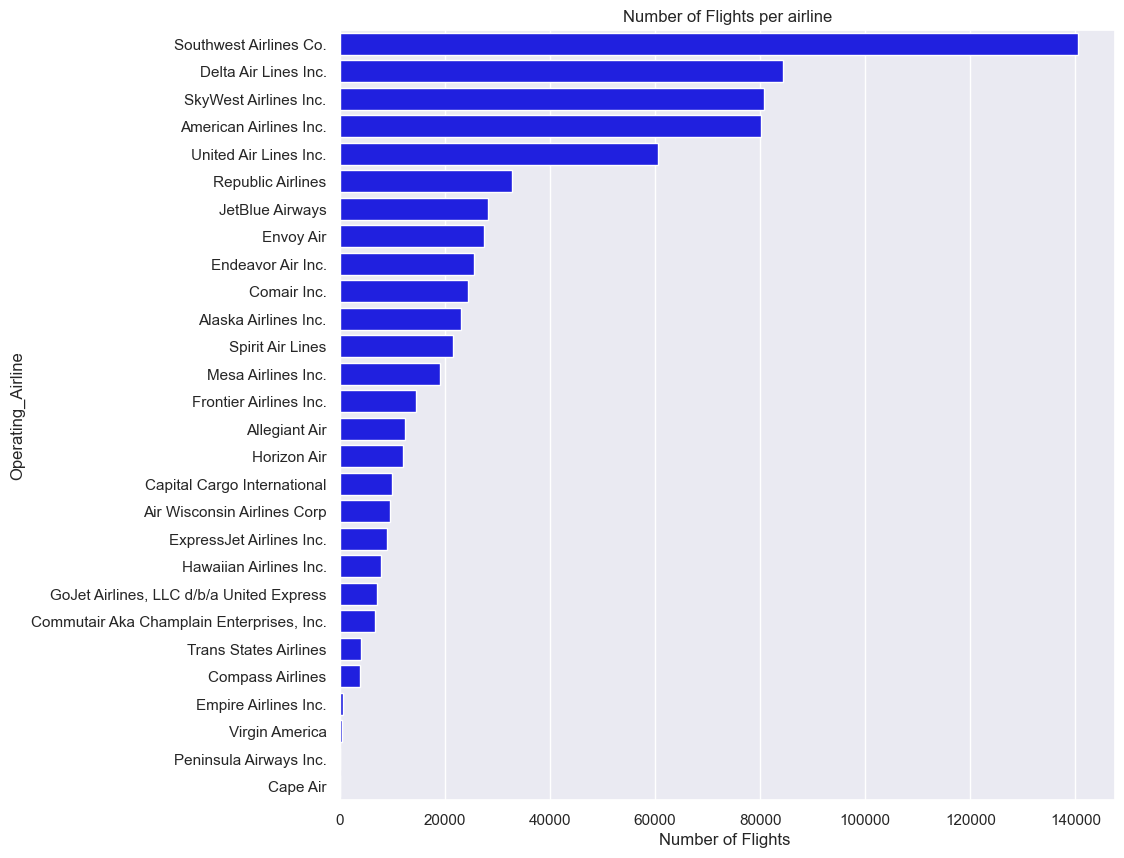

In [14]:
fig,ax = plt.subplots(figsize=(10,10))
sorted_airlines = df_flights["Operating_Airline"].value_counts().index.tolist()
sns.countplot(y=df_flights["Operating_Airline"], order=sorted_airlines, color='blue')
ax.set_title("Number of Flights per airline")
ax.set_xlabel("Number of Flights ")

In [15]:
fig = px.line(df_flights
              .groupby("FlightDate")
              [["DepDelayMinutes"]]
              .mean(),
              title="Distribution of flight delays"
              )
fig.show()


In [16]:
fig = px.bar(df_flights
              .groupby("Operating_Airline")
              [["DepDelayMinutes"]]
              .mean(),
              title="Distribution of flight delays by airline"
              )
fig.show()

In [17]:
fig = px.line(df_flights
              .groupby("FlightDate")
              [["Cancelled"]]
              .mean(),
              title="Distribution of flight cancellations"
              )
fig.show()

In [18]:
fig = px.bar(df_flights
              .groupby("Operating_Airline")
              [["Cancelled"]]
              .mean(),
              title="Distribution of flight cancellations by airline",
              height=700
              )
fig.show()

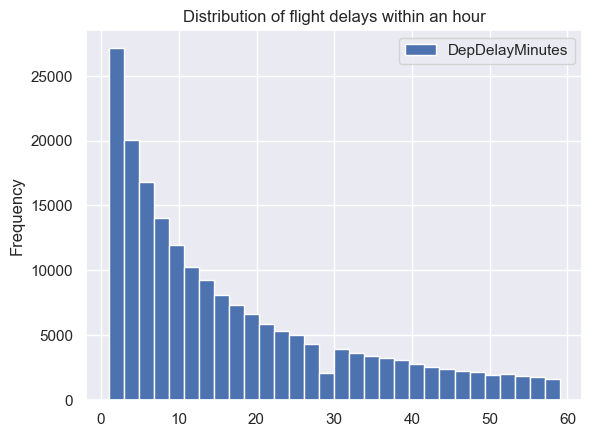

In [19]:
(df_flights
 .query("DepDelayMinutes > 0 and DepDelayMinutes < 60")
 [["DepDelayMinutes"]]
 .plot(kind="hist", bins=30, title="Distribution of flight delays within an hour"))
plt.show()


In [20]:
df_flights_2.head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,DestAirportID,CRSDepTime,DepTime,DepDelayMinutes,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,Cancelled,CRSElapsedTime,AirTime,Distance,TotalAddGTime,latitude,longitude,DepDelayClass
0,2018-01-07,Endeavor Air Inc.,N8980A,3298,10397,10146,1037,1034.0,0.0,18.0,1121.0,3.0,1137,0.0,60.0,29.0,145.0,0.0,33.6250,-84.4375,OnTime
1,2018-01-16,Endeavor Air Inc.,N8721B,3301,10397,11617,1225,1220.0,0.0,12.0,1328.0,3.0,1350,0.0,85.0,56.0,433.0,0.0,33.6250,-84.4375,OnTime
2,2018-01-28,Endeavor Air Inc.,N8969A,3301,11617,10397,1415,1516.0,61.0,12.0,1648.0,11.0,1605,0.0,110.0,80.0,433.0,0.0,35.0625,-77.0625,Delay45_180
3,2018-01-02,Endeavor Air Inc.,N8894A,3301,13277,10397,1528,1526.0,0.0,27.0,1722.0,8.0,1734,0.0,66.0,29.0,147.0,0.0,32.3125,-86.3750,OnTime
4,2018-01-16,Endeavor Air Inc.,N8683B,3302,11641,10397,1853,0.0,0.0,0.0,0.0,0.0,2030,1.0,97.0,0.0,331.0,0.0,35.0000,-78.8750,Cancelled


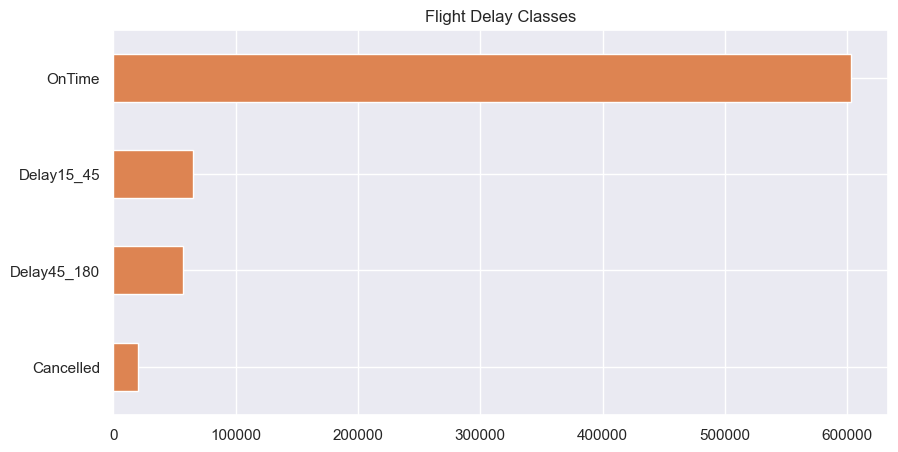

In [21]:
(df_flights
 .DepDelayClass
 .value_counts(ascending=True)
 .plot(kind='barh', figsize=(10,5), color=current_palette[1], title="Flight Delay Classes")
 )
plt.show()

Percentage of flights per year 

In [22]:
df_flights["Year"] = df_flights["FlightDate"].dt.year
df_flights_agg = df_flights.groupby("Year")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Year,,,,
2018,1.532825,9.644727,8.172962,80.649486
2019,1.925951,9.142328,8.618284,80.313437
2020,6.000048,4.620809,3.856776,85.522368
2021,1.778116,8.955800,7.556358,81.709726
2022,3.003100,11.040809,9.750733,76.205359


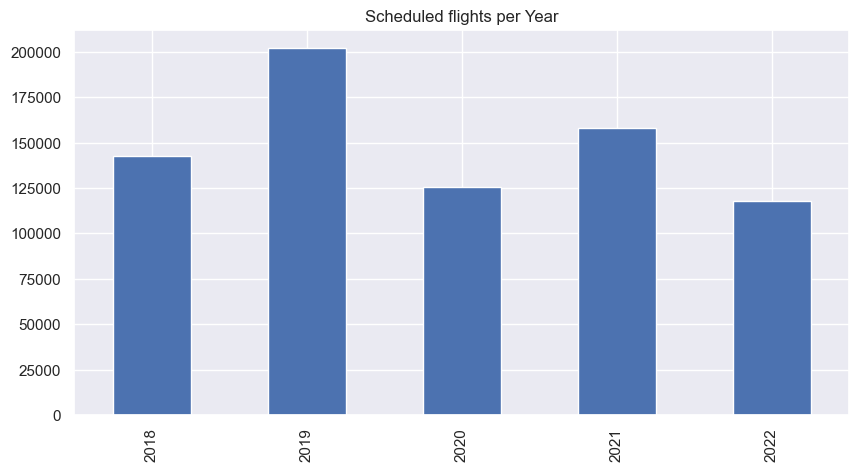

In [23]:
df_flights["Year"].value_counts().sort_index().plot(kind="bar", figsize=(10,5), title="Scheduled flights per Year")
plt.show()

In [24]:
px.bar(
    df_flights["Year"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='v',
    template="plotly_dark",
    title="Scheduled flights per year",
    height=700,
)

Percentage of Flights by Month

In [25]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.groupby("Month")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Month,,,,
1,3.074900,7.993853,7.005334,81.925913
2,3.058380,8.977933,7.692700,80.270987
3,5.684186,7.858224,6.255175,80.202415
4,6.732102,7.764053,6.962125,78.541719
5,1.982502,8.928905,7.789009,81.299584
6,1.967530,10.738684,10.533903,76.759883
7,1.676218,10.072156,10.006830,78.244796
8,2.308764,9.640249,9.405293,78.645694
9,1.396724,6.700648,5.851730,86.050899


- Why the high cancellations in March - April?
- Lets analyse per year for these months 

In [26]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.query("3 <= Month <= 4").groupby("Year")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Year,,,,
2018,1.728039,9.756919,7.465704,81.049338
2019,2.271193,8.720913,7.928636,81.079257
2020,24.790522,3.386726,2.996999,68.825753
2021,0.884658,5.994608,4.128402,88.992333
2022,1.882152,10.732707,9.561059,77.824082


The analysis shows that the majority of cancellations happened in 2020 March -April 2020, which was when we had covid-19

- How about the situation without 2020?

In [27]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.query("Year != 2020").groupby("Month")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Month,,,,
1,3.599389,8.157833,7.357316,80.885462
2,3.834836,9.632273,8.014922,78.517969
3,1.813245,9.035847,7.083998,82.066910
4,1.701118,8.704868,7.791808,81.802207
5,1.567590,9.464762,8.345055,80.622594
6,2.143765,11.526593,11.368669,74.960973
7,1.819560,11.093115,11.020746,76.066579
8,2.519551,10.587023,10.426688,76.466739
9,1.520227,7.356351,6.529674,84.593747


  Observations
  - Without the year 2020 when covid-19 was at its peak, we see that most cancellations happened in the months of January and February, this would be due to the weather
    - Winter: December, January, February
    - Spring: March, April, May
    - Summer: June, July, August
    - Autumn: September, October, November

Lets group by Month and Year analyse the cancellations

In [28]:
df_flights_agg = df_flights.query("Cancelled > 0").groupby(["Month", "Year"]).size().unstack()
df_flights_agg.style.background_gradient(cmap="YlGnBu")

Year,2018,2019,2020,2021,2022
Month,,,,,
1,301.000000,500.000000,242.000000,101.000000,937.000000
2,121.000000,457.000000,144.000000,507.000000,570.000000
3,231.000000,367.000000,3027.000000,134.000000,223.000000
4,128.000000,407.000000,3334.000000,76.000000,328.000000
5,107.000000,368.000000,320.000000,55.000000,317.000000
6,113.000000,374.000000,20.000000,243.000000,451.000000
7,140.000000,384.000000,73.000000,243.000000,289.000000
8,319.000000,314.000000,101.000000,486.000000,421.000000
9,225.000000,271.000000,62.000000,212.000000,nan


(<Figure size 2000x1000 with 5 Axes>,
 array([<AxesSubplot: ylabel='2018'>, <AxesSubplot: ylabel='2019'>,
        <AxesSubplot: ylabel='2020'>, <AxesSubplot: ylabel='2021'>,
        <AxesSubplot: ylabel='2022'>], dtype=object))

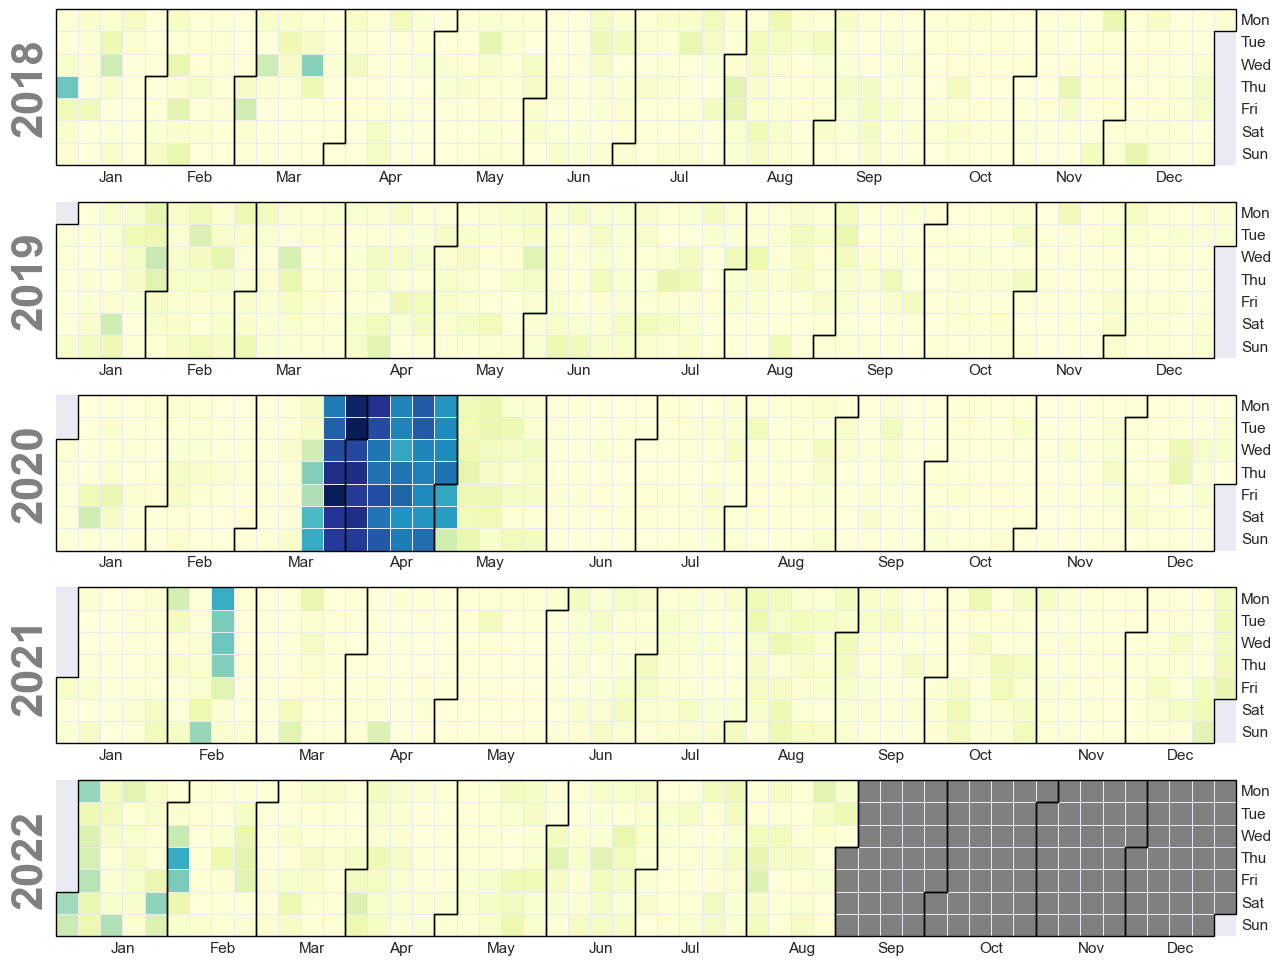

In [29]:
events = df_flights.groupby("FlightDate")["Cancelled"].mean()
calmap.calendarplot(events, monthticks=3, daylabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                    dayticks=True, cmap='YlGnBu',
                    fillcolor='grey', linewidth=0.5, monthly_border=True, 
                    fig_kws=dict(figsize=(20, 10)))

In [30]:
fig = calplot(
         events.reset_index(),
         x="FlightDate",
         y="Cancelled",
         colorscale="Reds",
         years_title=True
)
fig.show()

In [31]:
df_flights.groupby(["Operating_Airline"])[["DepDelayClass"]].value_counts(normalize=True).unstack()

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Operating_Airline,,,,
Air Wisconsin Airlines Corp,0.037599,0.061060,0.090909,0.810432
Alaska Airlines Inc.,0.019022,0.084778,0.053002,0.843197
Allegiant Air,0.042761,0.113162,0.099667,0.744411
American Airlines Inc.,0.031616,0.088565,0.080911,0.798908
Cape Air,0.000000,0.048780,0.024390,0.926829
Capital Cargo International,0.038477,0.067410,0.069319,0.824794
Comair Inc.,0.032935,0.073357,0.080108,0.813600
"Commutair Aka Champlain Enterprises, Inc.",0.043235,0.082691,0.137868,0.736206
Compass Airlines,0.014838,0.078025,0.085444,0.821694


<AxesSubplot: ylabel='Operating_Airline'>

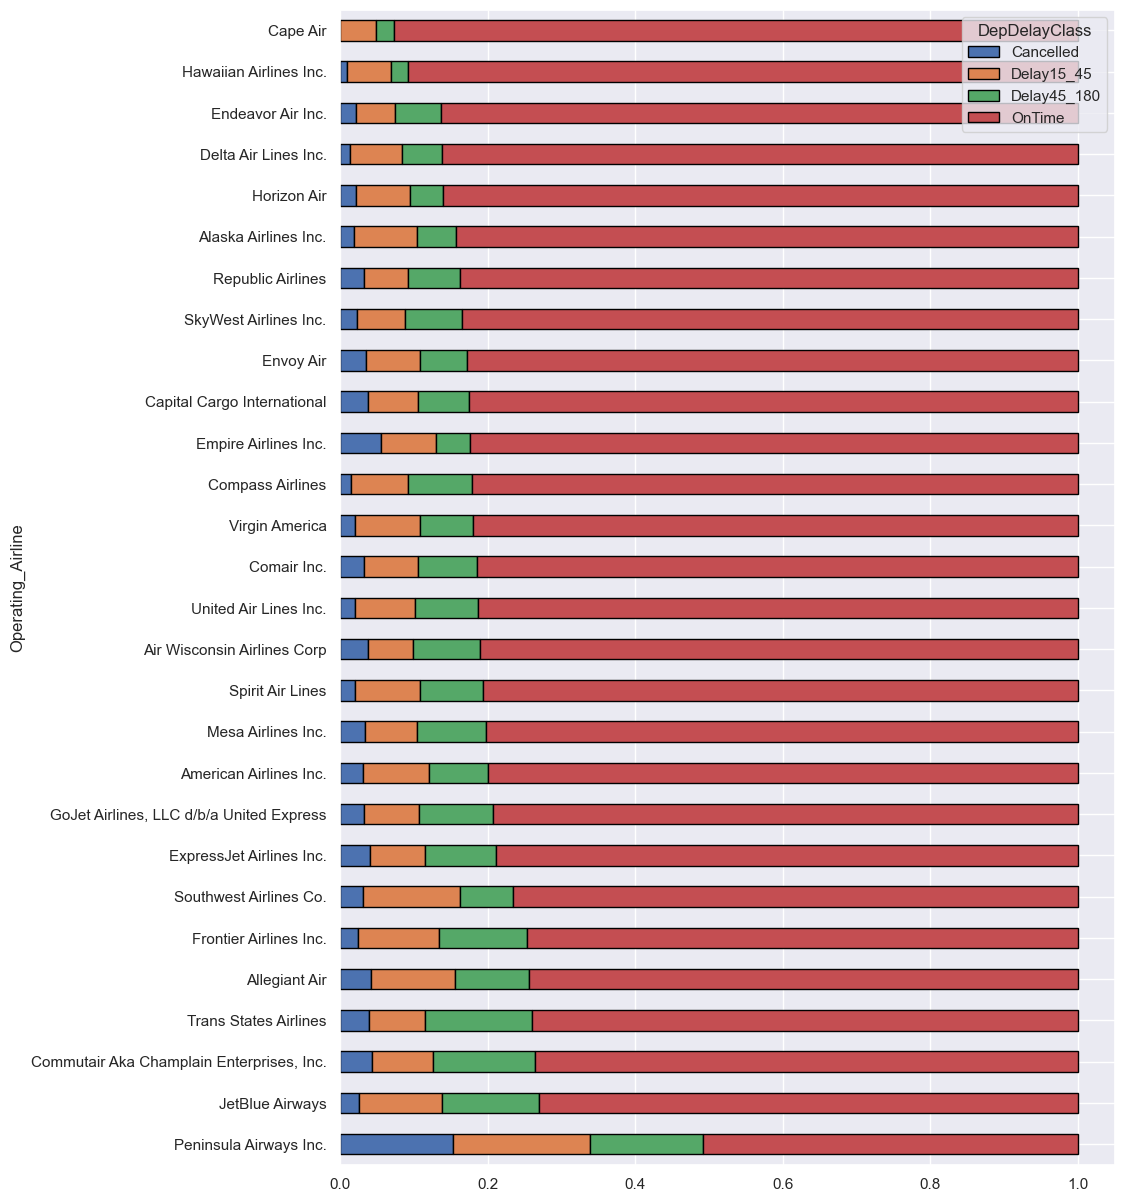

In [32]:
stacked_df_flights = df_flights.groupby(["Operating_Airline"])[["DepDelayClass"]].value_counts(normalize=True).unstack()
stacked_df_flights.sort_values("OnTime").plot(kind='barh', figsize=(10,15), stacked=True, edgecolor="black")

In [33]:
fig = px.bar(stacked_df_flights.sort_values("OnTime"), barmode='stack', height=700, orientation='h')
fig.show()


#### Correlation [Pearson]

In [34]:
corr = (df_flights_2
        .select_dtypes('float16')
        .corr())
corr.style.background_gradient(cmap='coolwarm')


,DepTime,DepDelayMinutes,TaxiOut,WheelsOn,TaxiIn,CRSElapsedTime,AirTime,Distance,TotalAddGTime,latitude,longitude
DepTime,1.000000,0.121513,0.118539,0.732219,0.045516,-0.015887,0.077105,-0.008553,0.022112,-0.034937,-0.002884
DepDelayMinutes,0.121513,1.000000,0.064110,0.034615,0.023479,0.014094,0.017324,0.010608,0.215496,0.000587,0.024974
TaxiOut,0.118539,0.064110,1.000000,0.139622,0.076063,0.067904,0.104030,0.029402,0.024495,0.080449,0.102823
WheelsOn,0.732219,0.034615,0.139622,1.000000,0.076538,0.025741,0.123798,0.026238,-0.017829,-0.017296,-0.001516
TaxiIn,0.045516,0.023479,0.076063,0.076538,1.000000,0.099229,0.120842,0.068581,-0.002507,-0.002812,0.048952
CRSElapsedTime,-0.015887,0.014094,0.067904,0.025741,0.099229,1.000000,0.946851,0.982276,0.006654,-0.040584,-0.030744
AirTime,0.077105,0.017324,0.104030,0.123798,0.120842,0.946851,1.000000,0.943234,-0.007279,-0.056756,-0.060740
Distance,-0.008553,0.010608,0.029402,0.026238,0.068581,0.982276,0.943234,1.000000,0.002732,-0.075007,-0.124120
TotalAddGTime,0.022112,0.215496,0.024495,-0.017829,-0.002507,0.006654,-0.007279,0.002732,1.000000,0.008554,0.019158
latitude,-0.034937,0.000587,0.080449,-0.017296,-0.002812,-0.040584,-0.056756,-0.075007,0.008554,1.000000,0.010019


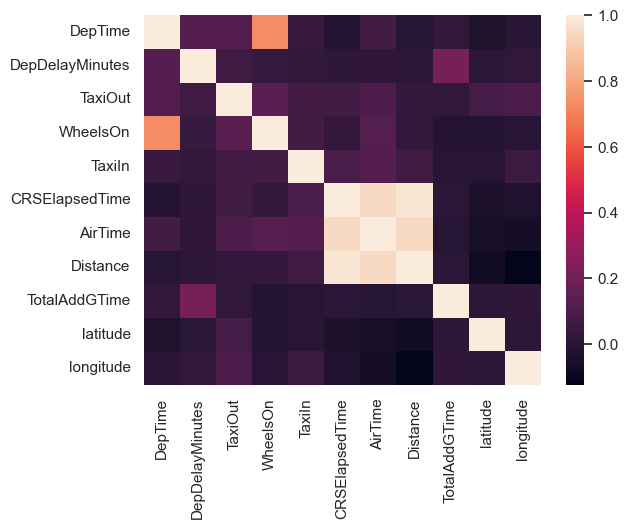

In [35]:
sns.heatmap(
    (df_flights_2
     .select_dtypes('float16')
     .corr()))
plt.show()


In [36]:
# Factors affecting delay
# Assumption: A flight is counted as "on time" if it operated less than 15 minutes later than the
def flight_status(df_flights):
        df_flights["FlightStatus"]="OnTime"

        df_flights.loc[df_flights["DepDel15"] == 0, "FlightStatus"]="OnTime"
        df_flights.loc[(df_flights["DepDelayMinutes"] >= 0) & (df_flights["DepDelayMinutes"] <= 15), "FlightStatus"]="OnTime"
        df_flights.loc[df_flights["WeatherDelay"] > 15, "FlightStatus"]="WeatherDelay"
        df_flights.loc[df_flights["NASDelay"] > 15, "FlightStatus"]="NASDelay"
        df_flights.loc[df_flights["SecurityDelay"] > 15, "FlightStatus"]="SecurityDelay"
        df_flights.loc[df_flights["LateAircraftDelay"] > 15, "FlightStatus"]="LateAircraftDelay"
        df_flights.loc[df_flights["CarrierDelay"] > 15, "FlightStatus"]="CarrierDelay"
        df_flights.loc[df_flights["Cancelled"], "FlightStatus"]="Cancelled"
    

flight_status(df_flights)

<AxesSubplot: xlabel='FlightDate'>

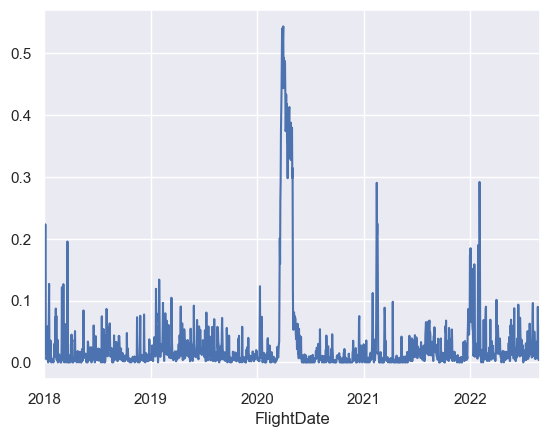

In [37]:
(df_flights.
 groupby("FlightDate")
 ["Cancelled"]
 .agg("mean")
 .plot()
 )


<AxesSubplot: xlabel='FlightDate'>

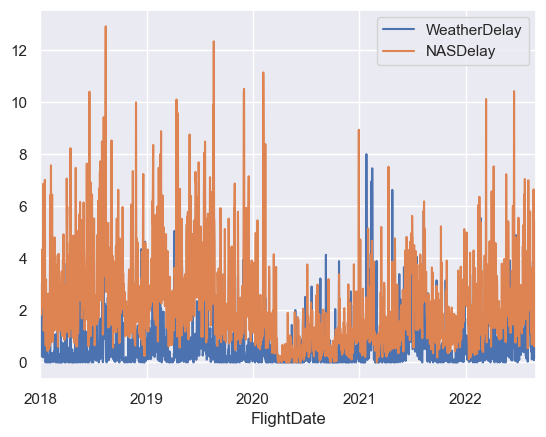

In [38]:
(df_flights.
 groupby("FlightDate")
 [["WeatherDelay", "NASDelay"]]
 .agg("mean")
 .plot())


<AxesSubplot: xlabel='FlightDate'>

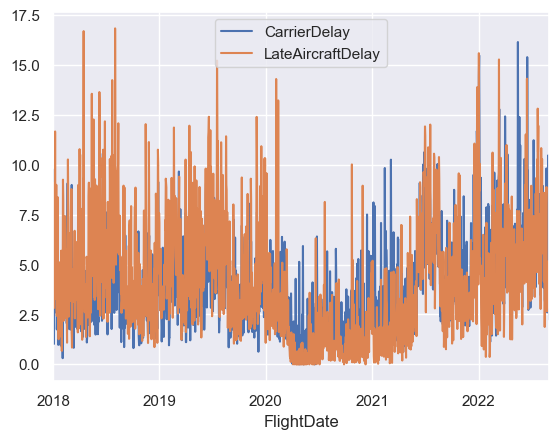

In [39]:
(df_flights.
 groupby("FlightDate")
 [["CarrierDelay", "LateAircraftDelay"]]
 .agg("mean")
 .plot())


##### Frequency Distribution Table

In [40]:
(df_flights
 [["Operating_Airline"]]
 .value_counts()
 .sort_values(ascending=False)
 .to_frame("Row Count")
 )


,Row Count
Operating_Airline,
Southwest Airlines Co.,140501
Delta Air Lines Inc.,84315
SkyWest Airlines Inc.,80635
American Airlines Inc.,80212
United Air Lines Inc.,60637
Republic Airlines,32737
JetBlue Airways,28253
Envoy Air,27469
Endeavor Air Inc.,25511


In [41]:
px.bar(
    df_flights["Operating_Airline"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='h',
    template="plotly_dark",
    title="Flights per airline",
    height=700,
)


In [42]:
df_flights.head(3)

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,DepDelayClass_ordinal,Year,Month,FlightStatus
0,2018-01-07,Endeavor Air Inc.,N8980A,3298,10397,ATL,"Atlanta, GA",GA,Georgia,10146,ABY,"Albany, GA",GA,Georgia,1037,1034.0,-3.0,0.0,0.0,1000-1059,18.0,1121.0,3.0,1137,1124.0,0.0,0.0,1100-1159,0.0,none,False,60.0,29.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.6250,-84.4375,OnTime,1,2018,1,Cancelled
1,2018-01-16,Endeavor Air Inc.,N8721B,3301,10397,ATL,"Atlanta, GA",GA,Georgia,11617,EWN,"New Bern/Morehead/Beaufort, NC",NC,North Carolina,1225,1220.0,-5.0,0.0,0.0,1200-1259,12.0,1328.0,3.0,1350,1331.0,0.0,0.0,1300-1359,0.0,none,False,85.0,56.0,433.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.6250,-84.4375,OnTime,1,2018,1,Cancelled
2,2018-01-28,Endeavor Air Inc.,N8969A,3301,11617,EWN,"New Bern/Morehead/Beaufort, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1415,1516.0,61.0,1.0,61.0,1400-1459,12.0,1648.0,11.0,1605,1659.0,54.0,1.0,1600-1659,0.0,none,False,110.0,80.0,433.0,1.0,0.0,0.0,0.0,53.0,0.0,0.0,35.0625,-77.0625,Delay45_180,3,2018,1,LateAircraftDelay


In [43]:
cols = ["FlightDate","Tail_Number","Flight_Number","Operating_Airline", "OriginCityName","DestCityName", "CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]
(df_flights
 .loc[df_flights["DepDelayMinutes"] >10, cols ]
 .sort_values(by=["Flight_Number", "FlightDate", "CRSDepTime"],ascending=[True, True, True]))

,FlightDate,Tail_Number,Flight_Number,Operating_Airline,OriginCityName,DestCityName,CRSDepTime,DepTime,DepDelayMinutes,AirTime,FlightStatus
10390,2018-01-12,N8325D,1,Southwest Airlines Co.,"Dallas, TX","Houston, TX",700,717.0,17.0,45.0,OnTime
46046,2018-05-03,N957JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1025,1041.0,16.0,135.0,OnTime
67864,2018-08-13,N952JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1058,1311.0,133.0,162.0,LateAircraftDelay
75884,2018-08-15,N284WN,1,Southwest Airlines Co.,"Houston, TX","Corpus Christi, TX",840,917.0,37.0,32.0,CarrierDelay
80996,2018-09-07,N516JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1029,1055.0,26.0,141.0,OnTime
129573,2018-12-20,N8699A,1,Southwest Airlines Co.,"Houston, TX","Nashville, TN",855,914.0,19.0,84.0,OnTime
269728,2019-08-07,N7825A,1,Southwest Airlines Co.,"Dallas, TX","Houston, TX",700,719.0,19.0,41.0,OnTime
330962,2019-12-12,N922VA,1,Alaska Airlines Inc.,"Washington, DC","Seattle, WA",800,822.0,22.0,338.0,OnTime
333409,2019-12-15,N2016J,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",800,811.0,11.0,153.0,OnTime
343527,2019-12-30,N7863A,1,Southwest Airlines Co.,"Houston, TX","Jacksonville, FL",845,913.0,28.0,94.0,OnTime


In [44]:
cols = ["FlightDate","Tail_Number","Flight_Number","Operating_Airline", "OriginCityName","DestCityName", "CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]
(df_flights[cols]
 .groupby(["Flight_Number", "Operating_Airline"])
 [["DepDelayMinutes"]]
 .mean())

DepDelayMinutes
Flight_Number Operating_Airline                                         
1             Air Wisconsin Airlines Corp                            NaN
              Alaska Airlines Inc.                              7.151515
              Allegiant Air                                     0.000000
              American Airlines Inc.                            1.090909
              Cape Air                                               NaN
              Capital Cargo International                            NaN
              Comair Inc.                                            NaN
              Commutair Aka Champlain Enterprises, Inc.              NaN
              Compass Airlines                                       NaN
              Delta Air Lines Inc.                                   NaN
...                                                                  ...
9677          JetBlue Airways                                        NaN
              Mesa Airlines Inc.                                     NaN
              Peninsula Airways Inc.                                 NaN
              Republic Airlines                              4320.000000
              SkyWest Airlines Inc.                                  NaN
              Southwest Airlines Co.                                 NaN
              Spirit Air Lines                                       NaN
              Trans States Airlines                                  NaN
              United Air Lines Inc.                                  NaN
              Virgin America                                         NaN

[198660 rows x 1 columns]